<h1 style="font-size:30px;">Learning Rate Schedulers</h1>

When training a model from scratch, we generally start with a higher learning rate, but as the learning progresses, reducing the learning rate can help improve the rate of convergence and sometimes even results in increased accuracy (lower loss). In TensorFlow, we can add Learning Rate Schedulers using the [`tf.keras.optimizers.schedules`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules) module. 

In this notebook, we will learn about three different learning rate schedulers in TensorFlow using the [Rock, Paper, Scissors](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors) data from TensorFlow datasets [tfds](https://www.tensorflow.org/datasets/api_docs/python/tfds). Specifically, we'll take a look at the following learning rate schedulers:

* Piecewise Constant Decay
* Inverse Time Decay
* Exponential Decay


<img src='https://opencv.org/wp-content/uploads/2022/08/c4-04-learning-rate-feature-image.png' width=1000 align='center'><br/>




## Table of Contents
* [1 System Configuration](#1-System-Configuration)
* [2 Training and Dataset Configurations](#2-Training-and-Dataset-Configurations)
* [3 Rock-Paper-Scissors Dataset](#3-Rock-Paper-Scissors-Dataset)
* [4 LeNet5 Model](#4-LeNet5-Model)
* [5 Training Function](#5-Training-Function)
* [6 Training using SGD (Gradient Desent) with Momentum](#6-Training-using-SGD-%28Gradient-Desent%29-with-Momentum)
* [7 Training with Learning Rate Schedulers](#7-Training-with-Learning-Rate-Schedulers)
    * [7.1 PiecewiseConstantDecay Scheduler](#7.1-PiecewiseConstantDecay-Scheduler)
    * [7.2 InverseTimeDecay Scheduler](#7.2-InverseTimeDecay-Scheduler)
    * [7.3 ExponentialDecay Scheduler](#7.3-ExponentialDecay-Scheduler)
* [8 Plot Loss Curves](#8-Plot-Loss-Curves)
* [9 Conclusion](#9-Conclusion)

In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import random
import tensorflow_datasets as tfds

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence

from tensorflow.keras.layers import (Conv2D, Activation, Input,
                                     MaxPool2D, Flatten, Dense)

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

block_plot = False

## 1 System Configuration

In [ ]:
def system_config():
    
    # Get list of GPUs.
    gpu_devices = tf.config.list_physical_devices('GPU')
    print(gpu_devices)
    
    if len(gpu_devices) > 0:
        print('Using GPU')
        os.environ["CUDA_VISIBLE_DEVICES"] = '0'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
        
        # If there are any gpu devices, use first gpu.
        tf.config.experimental.set_visible_devices(gpu_devices[0], 'GPU')
        
        # Grow the memory usage as it is needed by the process.
        tf.config.experimental.set_memory_growth(gpu_devices[0], True)
        
        # Enable using cudNN.
        os.environ['TF_USE_CUDNN'] = "true"
    else:
        print('Using CPU')

system_config()

[]
Using CPU


## 2 Training and Dataset Configurations

In [ ]:
@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:    int   = 32
    EPOCHS:        int   = 51
    LEARNING_RATE: float = 0.0001
    ROOT_LOG_DIR         = "./scheduler_logs"
    ROOT_CHECKPOINT_DIR  = "./scheduler_saved_models"
    
@dataclass(frozen=True)
class DatasetConfig:
    IMG_HEIGHT:   int = 32
    IMG_WIDTH:    int = 32
    CHANNELS:     int = 3
    NUM_CLASSES:  int = 3

## 3 Rock-Paper-Scissors Dataset

In [ ]:
# Define a dictionary mapping labels names to label IDs.
label_names = {
    'Rock'     : 0, 
    'Paper'    : 1, 
    'Scissors' : 2, 
}

### 3.1 Load the Dataset

Load the dataset using the TensorFlow Dataset module: [tfds](https://www.tensorflow.org/datasets/api_docs/python/tfds)

In [ ]:
def get_data():
    
    # Download and split the data.
    rps_train = tfds.load(name="rock_paper_scissors", split=tfds.Split.TRAIN, batch_size=-1)
    rps_test  = tfds.load(name="rock_paper_scissors", split=tfds.Split.TEST, batch_size=-1)

    rps_train = tfds.as_numpy(rps_train)
    rps_test  = tfds.as_numpy(rps_test)

    X_train, y_train = rps_train["image"], rps_train["label"]
    X_test,  y_test  = rps_test["image"],  rps_test["label"]
    
    return (X_train, y_train), (X_test, y_test)

### 3.2 Data Preprocessing Pipeline

In [ ]:
def preprocess_dataset(train_set, valid_set, resize_to=None, num_classes=3, seed=3):

    (X_train, y_train) = train_set
    (X_valid, y_valid) = valid_set
    
    if len(X_train.shape) != 4:
        X_train = tf.expand_dims(X_train, axis=3)
        X_valid = tf.expand_dims(X_valid, axis=3)
        
    # Resize images if requested.
    if resize_to:
        if isinstance(resize_to, int):
            resize_to = (resize_to, resize_to)
            
        X_train = tf.image.resize(X_train, resize_to)
        X_valid = tf.image.resize(X_valid, resize_to)
        
    n_train = X_train.shape[0]
    n_valid = X_valid.shape[0]

    image_shape = X_train[0].shape

    print("There are {} training examples ".format(n_train))
    print("There are {} validation examples".format(n_valid))
    print("Image data shape is {}".format(image_shape))

    # Confirm the number of classes present in the dataset matches the specified number of classes.
    assert num_classes == len(np.unique(y_train)
    ), "Number of classes present in the dataset does not match specified nuber of classes."
    
    print('There are {} classes'.format(num_classes))

    # One-hot encode labels if necessary.
    if len(y_train.shape) != 2:
        y_train = to_categorical(y_train, num_classes)
        y_valid = to_categorical(y_valid, num_classes)
        
    print(f"\n\nX_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"X_valid: {X_valid.shape}, y_validation: {y_valid.shape}")

    X_train = tf.cast(X_train, dtype=tf.float32)
    X_valid = tf.cast(X_valid, dtype=tf.float32)

    # Normalize the pixel values to the range [0., 1.0].
    X_train = X_train / 255.0
    X_valid = X_valid / 255.0

    return (X_train, y_train), (X_valid, y_valid)

### 3.3 Data Visualization

In [ ]:
def visualize_samples(X, y):
    plt.figure(figsize=(18, 8))
    
    for i in range(8):
        plt.subplot(2, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(X[i], cmap=plt.cm.binary)
        plt.xlabel(list(label_names.keys())[y[i]])
        
    plt.suptitle("Dataset Samples")
    plt.show(block=block_plot)

Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


2022-07-31 15:58:26.820065: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


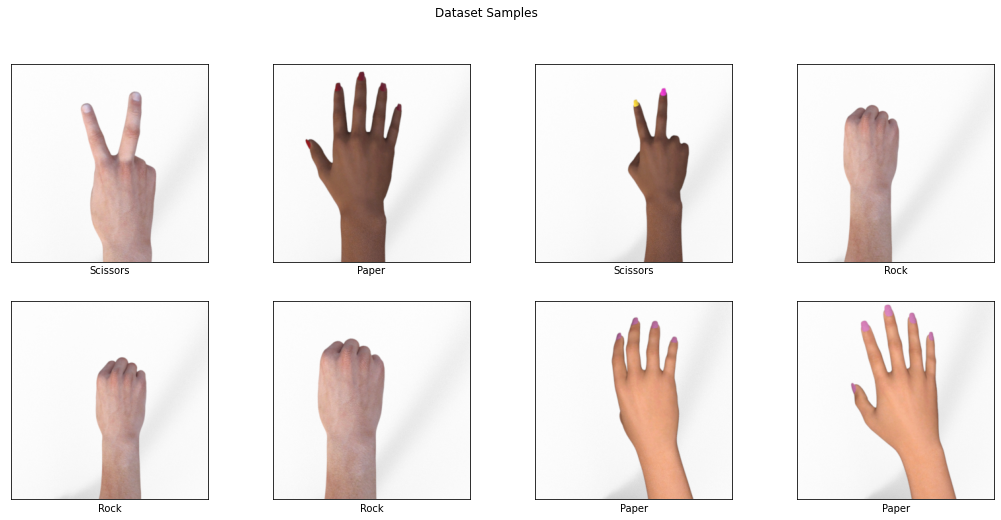

In [ ]:
# Load the dataset.
(X_train_in, y_train_in), (X_valid_in, y_valid_in) = get_data()

visualize_samples(X_valid_in, y_valid_in)

### 3.4 Preprocess the Dataset

In [ ]:
# Preprocess the dataset.
((X_train, y_train),
(X_valid, y_valid)) = preprocess_dataset((X_train_in, y_train_in),
                                        (X_valid_in, y_valid_in),
                                        resize_to=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH),
                                        num_classes=DatasetConfig.NUM_CLASSES,
                                        )

There are 2520 training examples 
There are 372 validation examples
Image data shape is (32, 32, 3)
There are 3 classes


X_train: (2520, 32, 32, 3), y_train: (2520, 3)
X_valid: (372, 32, 32, 3), y_validation: (372, 3)


## 4 LeNet5 Model

In [ ]:
def LeNet5_model(num_classes, shape, print_model_summary=True):

    inputs = Input(shape=shape)
    
    # -------------------------------------
    # First convolutional Layer + pooling
    # -------------------------------------
    x = Conv2D(6, 5, padding='valid')(inputs)              # input size = (32, 32), output size = (28, 28)
    x = Activation("relu")(x)                              # output size = (28, 28)
    x = MaxPool2D()(x)                                     # output size = (14, 14)

    # -------------------------------------
    # Second convolutional layer + pooling 
    # -------------------------------------
    x = Conv2D(16, 5, padding='valid')(x)                  # input size = (14, 14), output size = (10, 10)
    x = Activation('relu')(x)                              # output size = (10, 10)
    feature_extractor_output = MaxPool2D()(x)              # output size = (5, 5)

    # Flatten.
    flattened = Flatten()(feature_extractor_output)        # 5 * 5 * 16 -> 400

    # ------------------------- 
    # Fully connected layers.
    # -------------------------
    x = Dense(120, activation='relu')(flattened)           # 400 -> 120
    x = Dense(84, activation='relu')(x)                    # 120 -> 84
    
    # Softmax output layer.
    headout = Dense(num_classes, activation="softmax")(x)  # 84 -> 10
    
    # Create model.
    model = Model(inputs=inputs, outputs=headout, name='LeNet5')
    
    if print_model_summary:
        model.summary()
        
    return model

## 5 Training Function

In [ ]:
def train_model(train_set,
                valid_set,
                scheduler,
                version_number,
                epochs=TrainingConfig.EPOCHS,
                print_model_summary=False,
               ):
    
    os.makedirs(TrainingConfig.ROOT_LOG_DIR, exist_ok=True)
    os.makedirs(TrainingConfig.ROOT_CHECKPOINT_DIR, exist_ok=True)

    folders = os.listdir(TrainingConfig.ROOT_LOG_DIR)

    if len(folders):
        last_version_number = int(sorted(folders)[-1].replace("version_", ""))
        version_number = last_version_number + 1

    log_dir = os.path.join(TrainingConfig.ROOT_LOG_DIR, f"version_{version_number}")
    checkpoint_dir = os.path.join(TrainingConfig.ROOT_CHECKPOINT_DIR, f"version_{version_number}")

    os.makedirs(log_dir, exist_ok=True)
    os.makedirs(checkpoint_dir, exist_ok=True)

    print(f"Logging at: {log_dir}")

    (X_train, y_train) = train_set
    (X_valid, y_valdi) = valid_set
    
    # Initialize the LeNet Model.
    model = LeNet5_model(num_classes=DatasetConfig.NUM_CLASSES,
                         shape=(DatasetConfig.IMG_HEIGHT, DatasetConfig.IMG_WIDTH, DatasetConfig.CHANNELS),
                         print_model_summary=print_model_summary,
                        )
    
    # Compile the model for the requested scheduler.
    if scheduler=="Fixed":
        
        # Fixed learning rate.
        model.compile(tf.keras.optimizers.SGD(learning_rate=TrainingConfig.LEARNING_RATE, momentum=0.9),
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                      metrics=["accuracy"],
                     )
        
    elif scheduler=="PiecewiseConstantDecay":
        
        # Define the PiecewiseConstantDecay LR Scheduler.
        boundaries = [100, 500]
        values = [0.001, 0.0001, 0.00001]
        learning_rate_fn = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, values)
        step = tf.Variable(0, trainable=False)
        
        model.compile(tf.keras.optimizers.SGD(learning_rate=learning_rate_fn(step), momentum=0.9),
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                      metrics=["accuracy"],
                     )
        
    elif scheduler=="InverseTimeDecay":
        
        # Define the InverseTimeDecay LR Scheduler.
        initial_learning_rate = 0.1
        learning_rate_fn = tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate, 
                                                                          decay_steps=1, 
                                                                          decay_rate=0.5,
                                                                         )

        model.compile(tf.keras.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9),
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                      metrics=["accuracy"],
                     ) 
        
    elif scheduler=="ExponentialDecay":

        # Define the ExponentialDecay LR Scheduler.
        initial_learning_rate = 0.001                                                            
        learning_rate_fn = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,
                                                                          decay_steps=100, 
                                                                          decay_rate=0.96,
                                                                          staircase=True,
                                                                         )

        model.compile(tf.keras.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9),
                      loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                      metrics=["accuracy"],
                     )
    else:
        
        print("Invalid scheduler: ", scheduler)
        exit()

    # Initialize tensorboard callback for logging.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=TrainingConfig.ROOT_LOG_DIR,
                                                          histogram_freq=0,
                                                          write_graph=True,
                                                          write_images=False,
                                                          write_steps_per_second=False,
                                                          update_freq="epoch",
                                                          profile_batch=2,
                                                          embeddings_freq=0,
                                                          embeddings_metadata=None,
                                                         )

    # Save best model depending on the validation accuracy.
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=TrainingConfig.ROOT_CHECKPOINT_DIR,
                                                                   save_weights_only=False,
                                                                   monitor="val_accuracy",
                                                                   mode="max",
                                                                   save_best_only=True,
                                                                  )

    print(f"\nTraining for {epochs} epochs\n")
    
    results = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=TrainingConfig.BATCH_SIZE,
                        validation_data=(X_valid, y_valid),
                        callbacks=[tensorboard_callback, model_checkpoint_callback],
                       )

    return results, version_number

## 6 Training using SGD (Gradient Desent) with Momentum
Gradient descent update rule:

$$
W_t = W_{t-1} -\alpha g_{t-1}
$$

where,

$$
W = \begin{bmatrix}
           w_{1} \\
           w_{2} \\
           \vdots \\
           w_{n}
         \end{bmatrix}
$$

and,


$$
g = \begin{bmatrix}
           \frac{\partial L}{\partial w_1} \\
           \frac{\partial L}{\partial w_2}  \\
           \vdots \\
           \frac{\partial L}{\partial w_n} 
         \end{bmatrix}
$$

***Function Syntax:***

```
tf.keras.optimizers.SGD(learning_rate=0.01, 
                        momentum=0.0, 
                        nesterov=False, 
                        name='SGD', 
                        **kwargs,
                        )
```

- `learning_rate` – A Tensor, floating point value, or a schedule that is a `tf.keras.optimizers.schedules.LearningRateSchedule`, or a callable that takes no arguments and returns the actual value to use. The learning rate. Defaults to 0.01.

- `momentum` – float hyperparameter >= 0 that accelerates gradient descent in the relevant direction and dampens oscillations. Defaults to 0, i.e., vanilla gradient descent.

- `nesterov` – boolean. Whether to apply Nesterov momentum. Defaults to `False`.

- `name` – Optional name prefix for the operations created when applying gradients. Defaults to "SGD".

- `**kwargs` – Keyword arguments. Allowed to be one of "clipnorm" or "clipvalue". "clipnorm" (float) clips gradients by norm; "clipvalue" (float) clips gradients by value.

[SGD Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/SGD)

In the following training, we will use $\beta = 0.9$. Here $\beta$ is momentum.


In [ ]:
# Set the initial version number.
version_number = 0

# Train with SGD with momentum.
training_results_FIX, version_number = train_model(train_set=(X_train, y_train),
                                                   valid_set=(X_valid, y_valid),
                                                   scheduler='Fixed',
                                                   version_number=version_number,
                                                   epochs=TrainingConfig.EPOCHS, 
                                                   print_model_summary=True,
                                                  )

Logging at: ./scheduler_logs/version_0
Model: "LeNet5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 activation (Activation)     (None, 28, 28, 6)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 activation_1 (Activation)   (None, 10, 10, 16)        0         
                     

2022-07-31 15:58:29.103903: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-07-31 15:58:29.103917: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-07-31 15:58:29.104154: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.


14/79 [====>.........................] - ETA: 0s - loss: 1.1997 - accuracy: 0.3371

2022-07-31 15:58:29.533471: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-07-31 15:58:29.533492: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-07-31 15:58:29.548572: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2022-07-31 15:58:29.549588: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2022-07-31 15:58:29.551944: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./scheduler_logs/plugins/profile/2022_07_31_15_58_29

2022-07-31 15:58:29.552564: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./scheduler_logs/plugins/profile/2022_07_31_15_58_29/Rocket.local.trace.json.gz
2022-07-31 15:58:29.554935: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./scheduler_logs/plugins/profile/2022_07_31_15_58_29

2022-07-31 

75/79 [===========================>..] - ETA: 0s - loss: 1.1399 - accuracy: 0.3296

2022-07-31 15:58:30.971431: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 26ms/step - loss: 1.1387 - accuracy: 0.3250 - val_loss: 1.1006 - val_accuracy: 0.3333
Epoch 2/51
75/79 [===========================>..] - ETA: 0s - loss: 1.1000 - accuracy: 0.3021INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 22ms/step - loss: 1.1000 - accuracy: 0.3040 - val_loss: 1.0961 - val_accuracy: 0.3468
Epoch 3/51
77/79 [============================>.] - ETA: 0s - loss: 1.0926 - accuracy: 0.3758INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 22ms/step - loss: 1.0927 - accuracy: 0.3750 - val_loss: 1.0937 - val_accuracy: 0.3737
Epoch 4/51
78/79 [============================>.] - ETA: 0s - loss: 1.0866 - accuracy: 0.4319INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 22ms/step - loss: 1.0866 - accuracy: 0.4321 - val_loss: 1.0907 - val_accuracy: 0.3952
Epoch 5/51
79/79 [==============================] - 1s 14ms/step - loss: 1.0814 - accuracy: 0.4889 - val_loss: 1.0883 - val_accuracy: 0.3656
Epoch 6/51
79/79 [==============================] - 1s 13ms/step - loss: 1.0750 - accuracy: 0.5250 - val_loss: 1.0860 - val_accuracy: 0.3871
Epoch 7/51
79/79 [==============================] - 1s 13ms/step - loss: 1.0681 - accuracy: 0.5440 - val_loss: 1.0846 - val_accuracy: 0.3817
Epoch 8/51
79/79 [==============================] - 1s 13ms/step - loss: 1.0603 - accuracy: 0.5714 - val_loss: 1.0830 - val_accuracy: 0.3763
Epoch 9/51
79/79 [==============================] - ETA: 0s - loss: 1.0527 - accuracy: 0.5694INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 25ms/step - loss: 1.0527 - accuracy: 0.5694 - val_loss: 1.0809 - val_accuracy: 0.4005
Epoch 10/51
79/79 [==============================] - ETA: 0s - loss: 1.0444 - accuracy: 0.5770INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 22ms/step - loss: 1.0444 - accuracy: 0.5770 - val_loss: 1.0773 - val_accuracy: 0.4516
Epoch 11/51
79/79 [==============================] - 1s 12ms/step - loss: 1.0346 - accuracy: 0.5869 - val_loss: 1.0750 - val_accuracy: 0.4167
Epoch 12/51
75/79 [===========================>..] - ETA: 0s - loss: 1.0233 - accuracy: 0.5813INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 22ms/step - loss: 1.0234 - accuracy: 0.5810 - val_loss: 1.0709 - val_accuracy: 0.5188
Epoch 13/51
77/79 [============================>.] - ETA: 0s - loss: 1.0111 - accuracy: 0.5917INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 22ms/step - loss: 1.0105 - accuracy: 0.5937 - val_loss: 1.0682 - val_accuracy: 0.5296
Epoch 14/51
79/79 [==============================] - 1s 13ms/step - loss: 0.9961 - accuracy: 0.6179 - val_loss: 1.0674 - val_accuracy: 0.4194
Epoch 15/51
79/79 [==============================] - 1s 13ms/step - loss: 0.9793 - accuracy: 0.6222 - val_loss: 1.0621 - val_accuracy: 0.5242
Epoch 16/51
79/79 [==============================] - 1s 13ms/step - loss: 0.9614 - accuracy: 0.6218 - val_loss: 1.0607 - val_accuracy: 0.4866
Epoch 17/51
79/79 [==============================] - 1s 13ms/step - loss: 0.9425 - accuracy: 0.6198 - val_loss: 1.0602 - val_accuracy: 0.4731
Epoch 18/51
79/79 [==============================] - 1s 13ms/step - loss: 0.9236 - accuracy: 0.6266 - val_loss: 1.0681 - val_accuracy: 0.4489
Epoch 19/51
79/79 [==============================] - 1s 13ms/step - loss: 0.9023 - accuracy: 0.6377 - val_loss: 1.0613 - val_accuracy: 0.4543
Epoch 20/51
79/79 

INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 22ms/step - loss: 0.7474 - accuracy: 0.7313 - val_loss: 1.0014 - val_accuracy: 0.5511
Epoch 27/51
75/79 [===========================>..] - ETA: 0s - loss: 0.7223 - accuracy: 0.7433INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 24ms/step - loss: 0.7197 - accuracy: 0.7452 - val_loss: 0.9769 - val_accuracy: 0.5914
Epoch 28/51
79/79 [==============================] - 1s 13ms/step - loss: 0.6927 - accuracy: 0.7675 - val_loss: 1.0042 - val_accuracy: 0.4570
Epoch 29/51
79/79 [==============================] - 1s 13ms/step - loss: 0.6653 - accuracy: 0.7825 - val_loss: 0.9796 - val_accuracy: 0.5806
Epoch 30/51
79/79 [==============================] - 1s 13ms/step - loss: 0.6356 - accuracy: 0.8075 - val_loss: 0.9361 - val_accuracy: 0.5484
Epoch 31/51
79/79 [==============================] - 1s 13ms/step - loss: 0.6064 - accuracy: 0.8028 - val_loss: 0.9611 - val_accuracy: 0.5376
Epoch 32/51
79/79 [==============================] - 1s 13ms/step - loss: 0.5726 - accuracy: 0.8317 - val_loss: 0.9600 - val_accuracy: 0.5672
Epoch 33/51
78/79 [============================>.] - ETA: 0s - loss: 0.5466 - accuracy: 0.8462INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets

INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 22ms/step - loss: 0.5467 - accuracy: 0.8460 - val_loss: 0.8948 - val_accuracy: 0.6317
Epoch 34/51
79/79 [==============================] - ETA: 0s - loss: 0.5193 - accuracy: 0.8560INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 23ms/step - loss: 0.5193 - accuracy: 0.8560 - val_loss: 0.8735 - val_accuracy: 0.6613
Epoch 35/51
79/79 [==============================] - 1s 13ms/step - loss: 0.4881 - accuracy: 0.8659 - val_loss: 0.9128 - val_accuracy: 0.5968
Epoch 36/51
79/79 [==============================] - ETA: 0s - loss: 0.4615 - accuracy: 0.8714INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 22ms/step - loss: 0.4615 - accuracy: 0.8714 - val_loss: 0.8422 - val_accuracy: 0.6962
Epoch 37/51
79/79 [==============================] - 1s 14ms/step - loss: 0.4314 - accuracy: 0.8905 - val_loss: 0.8646 - val_accuracy: 0.6909
Epoch 38/51
79/79 [==============================] - 1s 13ms/step - loss: 0.4075 - accuracy: 0.8885 - val_loss: 0.8533 - val_accuracy: 0.6371
Epoch 39/51
79/79 [==============================] - 1s 14ms/step - loss: 0.3875 - accuracy: 0.9067 - val_loss: 0.9104 - val_accuracy: 0.6452
Epoch 40/51
79/79 [==============================] - 1s 13ms/step - loss: 0.3682 - accuracy: 0.9119 - val_loss: 0.8758 - val_accuracy: 0.6720
Epoch 41/51
79/79 [==============================] - 1s 13ms/step - loss: 0.3475 - accuracy: 0.9198 - val_loss: 0.8908 - val_accuracy: 0.6102
Epoch 42/51
79/79 [==============================] - 1s 13ms/step - loss: 0.3436 - accuracy: 0.9123 - val_loss: 0.8984 - val_accuracy: 0.6210
Epoch 43/51
79/79 

INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 24ms/step - loss: 0.2905 - accuracy: 0.9298 - val_loss: 0.9375 - val_accuracy: 0.7446
Epoch 46/51
79/79 [==============================] - 1s 14ms/step - loss: 0.2848 - accuracy: 0.9290 - val_loss: 0.9908 - val_accuracy: 0.6425
Epoch 47/51
79/79 [==============================] - 1s 14ms/step - loss: 0.2696 - accuracy: 0.9365 - val_loss: 0.9526 - val_accuracy: 0.6317
Epoch 48/51
79/79 [==============================] - 1s 14ms/step - loss: 0.2542 - accuracy: 0.9413 - val_loss: 1.0051 - val_accuracy: 0.5699
Epoch 49/51
79/79 [==============================] - 1s 14ms/step - loss: 0.2407 - accuracy: 0.9409 - val_loss: 0.9316 - val_accuracy: 0.6720
Epoch 50/51
79/79 [==============================] - 1s 14ms/step - loss: 0.2348 - accuracy: 0.9460 - val_loss: 0.9295 - val_accuracy: 0.6720
Epoch 51/51
79/79 [==============================] - 1s 13ms/step - loss: 0.2155 - accuracy: 0.9512 - val_loss: 0.9539 - val_accuracy: 0.6667


## 7 Training with Learning Rate Schedulers

### 7.1 PiecewiseConstantDecay Scheduler
The `PiecewiseConstantDecay` returns a 1-arg callable to compute the piecewise constant when passed the current optimizer step.

***Function Syntax:***

```
tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries, 
                                                     values, 
                                                     name=None)
```

where:
* `boundaries`: A list of Tensors or ints or floats with strictly increasing entries, and with all elements having the same type as the optimizer step.
* `values`: A list of Tensors or floats or ints that specifies the values for the intervals defined by boundaries. It should have one more element than boundaries, and all elements should have the same type.
* `name`: A string. Optional name of the operation. Defaults to 'PiecewiseConstant'.

[PiecewiseConstantDecay Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/PiecewiseConstantDecay)

In [ ]:
# Train with PiecwiseConstantDecay.
training_results_PCD, version_number = train_model(train_set=(X_train, y_train),
                                                   valid_set=(X_valid, y_valid),
                                                   scheduler='PiecewiseConstantDecay',
                                                   version_number=version_number,
                                                   epochs=TrainingConfig.EPOCHS, 
                                                   print_model_summary=False,
                                                  )

Logging at: ./scheduler_logs/version_1

Training for 51 epochs

Epoch 1/51


2022-07-31 15:59:33.488882: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-07-31 15:59:33.488898: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-07-31 15:59:33.488918: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.


12/79 [===>..........................] - ETA: 0s - loss: 1.1128 - accuracy: 0.2682

2022-07-31 15:59:33.837241: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-07-31 15:59:33.837253: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-07-31 15:59:33.869649: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2022-07-31 15:59:33.870280: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2022-07-31 15:59:33.871121: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./scheduler_logs/plugins/profile/2022_07_31_15_59_33

2022-07-31 15:59:33.874263: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./scheduler_logs/plugins/profile/2022_07_31_15_59_33/Rocket.local.trace.json.gz
2022-07-31 15:59:33.875334: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./scheduler_logs/plugins/profile/2022_07_31_15_59_33

2022-07-31 

78/79 [============================>.] - ETA: 0s - loss: 1.0797 - accuracy: 0.4419INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 25ms/step - loss: 1.0793 - accuracy: 0.4444 - val_loss: 1.0550 - val_accuracy: 0.5591
Epoch 2/51
79/79 [==============================] - 1s 14ms/step - loss: 0.9624 - accuracy: 0.6369 - val_loss: 0.9617 - val_accuracy: 0.5108
Epoch 3/51
76/79 [===========================>..] - ETA: 0s - loss: 0.7243 - accuracy: 0.7664INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 23ms/step - loss: 0.7223 - accuracy: 0.7698 - val_loss: 0.8867 - val_accuracy: 0.5995
Epoch 4/51
79/79 [==============================] - ETA: 0s - loss: 0.4821 - accuracy: 0.8635INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 23ms/step - loss: 0.4821 - accuracy: 0.8635 - val_loss: 0.8498 - val_accuracy: 0.7608
Epoch 5/51
79/79 [==============================] - 1s 13ms/step - loss: 0.3158 - accuracy: 0.9230 - val_loss: 0.7628 - val_accuracy: 0.7339
Epoch 6/51
78/79 [============================>.] - ETA: 0s - loss: 0.2192 - accuracy: 0.9435INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 26ms/step - loss: 0.2183 - accuracy: 0.9440 - val_loss: 0.6729 - val_accuracy: 0.7688
Epoch 7/51
78/79 [============================>.] - ETA: 0s - loss: 0.1363 - accuracy: 0.9740INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 23ms/step - loss: 0.1358 - accuracy: 0.9742 - val_loss: 0.6894 - val_accuracy: 0.7823
Epoch 8/51
77/79 [============================>.] - ETA: 0s - loss: 0.0805 - accuracy: 0.9894INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 24ms/step - loss: 0.0794 - accuracy: 0.9897 - val_loss: 0.6916 - val_accuracy: 0.7984
Epoch 9/51
77/79 [============================>.] - ETA: 0s - loss: 0.0569 - accuracy: 0.9923INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 25ms/step - loss: 0.0568 - accuracy: 0.9925 - val_loss: 0.6799 - val_accuracy: 0.8065
Epoch 10/51
79/79 [==============================] - 1s 14ms/step - loss: 0.0458 - accuracy: 0.9940 - val_loss: 0.7388 - val_accuracy: 0.8011
Epoch 11/51
79/79 [==============================] - 1s 14ms/step - loss: 0.0346 - accuracy: 0.9948 - val_loss: 0.7512 - val_accuracy: 0.8038
Epoch 12/51
75/79 [===========================>..] - ETA: 0s - loss: 0.0260 - accuracy: 0.9962INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 25ms/step - loss: 0.0263 - accuracy: 0.9960 - val_loss: 0.7302 - val_accuracy: 0.8091
Epoch 13/51
79/79 [==============================] - ETA: 0s - loss: 0.0213 - accuracy: 0.9968INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 26ms/step - loss: 0.0213 - accuracy: 0.9968 - val_loss: 0.6757 - val_accuracy: 0.8118
Epoch 14/51
79/79 [==============================] - 1s 14ms/step - loss: 0.0165 - accuracy: 0.9980 - val_loss: 0.7968 - val_accuracy: 0.7769
Epoch 15/51
79/79 [==============================] - 1s 14ms/step - loss: 0.0158 - accuracy: 0.9988 - val_loss: 0.7398 - val_accuracy: 0.8118
Epoch 16/51
79/79 [==============================] - 1s 15ms/step - loss: 0.0120 - accuracy: 0.9992 - val_loss: 0.7561 - val_accuracy: 0.8011
Epoch 17/51
79/79 [==============================] - 1s 15ms/step - loss: 0.0100 - accuracy: 0.9996 - val_loss: 0.7925 - val_accuracy: 0.7984
Epoch 18/51
79/79 [==============================] - 1s 15ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.7541 - val_accuracy: 0.8091
Epoch 19/51
79/79 [==============================] - 1s 14ms/step - loss: 0.0078 - accuracy: 0.9996 - val_loss: 0.7479 - val_accuracy: 0.7823
Epoch 20/51
79/79 

### 7.2 InverseTimeDecay Scheduler
This scheduler applies the inverse decay function to an optimizer step, given a provided initial learning rate.

$$
\alpha = \frac{\alpha_0}{1+\gamma n}
$$

where,
$\alpha_0$ = inital learning rate  
$\gamma$ = decay_rate  
$n$ = step / decay_steps

***Function Syntax:***

```
tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate, 
                                               decay_steps, 
                                               decay_rate, 
                                               staircase=False, 
                                               name=None,
                                               )
```

where:
* `initial_learning_rate`: A scalar `float32` or `float64` Tensor or a Python number. The initial learning rate.
* `decay_steps`: How often to apply decay.
* `decay_rate`: A Python number. The decay rate.
* `staircase`: Whether to apply decay in a discrete staircase, as opposed to continuous, fashion.
* `name`: String. Optional name of the operation. Defaults to 'InverseTimeDecay'.

The learning rate is computed as:

```python
def decayed_learning_rate(step):
  return initial_learning_rate / (1 + decay_rate * step / decay_steps)
```

[InverseTimeDecay Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/InverseTimeDecay)

In [ ]:
# Train with InverseTimeDecay.
training_results_ITD, version_number = train_model(train_set=(X_train, y_train),
                                                   valid_set=(X_valid, y_valid),
                                                   scheduler='InverseTimeDecay',
                                                   version_number=version_number,
                                                   epochs=TrainingConfig.EPOCHS, 
                                                   print_model_summary=False,
                                                  )

Logging at: ./scheduler_logs/version_2

Training for 51 epochs

Epoch 1/51


2022-07-31 16:00:38.203056: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-07-31 16:00:38.203072: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-07-31 16:00:38.203151: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.


11/79 [===>..........................] - ETA: 1s - loss: 1.1044 - accuracy: 0.3722

2022-07-31 16:00:38.564004: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-07-31 16:00:38.564016: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-07-31 16:00:38.598493: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2022-07-31 16:00:38.599135: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2022-07-31 16:00:38.599958: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./scheduler_logs/plugins/profile/2022_07_31_16_00_38

2022-07-31 16:00:38.600691: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./scheduler_logs/plugins/profile/2022_07_31_16_00_38/Rocket.local.trace.json.gz
2022-07-31 16:00:38.601930: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./scheduler_logs/plugins/profile/2022_07_31_16_00_38

2022-07-31 

77/79 [============================>.] - ETA: 0s - loss: 0.9343 - accuracy: 0.5296INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 26ms/step - loss: 0.9271 - accuracy: 0.5345 - val_loss: 0.8084 - val_accuracy: 0.5995
Epoch 2/51
78/79 [============================>.] - ETA: 0s - loss: 0.5207 - accuracy: 0.7917INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 24ms/step - loss: 0.5195 - accuracy: 0.7921 - val_loss: 0.6027 - val_accuracy: 0.7661
Epoch 3/51
79/79 [==============================] - 1s 15ms/step - loss: 0.3220 - accuracy: 0.8845 - val_loss: 0.7035 - val_accuracy: 0.7070
Epoch 4/51
79/79 [==============================] - 1s 15ms/step - loss: 0.2335 - accuracy: 0.9198 - val_loss: 0.6051 - val_accuracy: 0.7554
Epoch 5/51
77/79 [============================>.] - ETA: 0s - loss: 0.1776 - accuracy: 0.9464INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 24ms/step - loss: 0.1773 - accuracy: 0.9460 - val_loss: 0.5175 - val_accuracy: 0.7930
Epoch 6/51
79/79 [==============================] - 1s 14ms/step - loss: 0.1453 - accuracy: 0.9651 - val_loss: 0.5292 - val_accuracy: 0.7876
Epoch 7/51
79/79 [==============================] - ETA: 0s - loss: 0.1266 - accuracy: 0.9702INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 25ms/step - loss: 0.1266 - accuracy: 0.9702 - val_loss: 0.5055 - val_accuracy: 0.7957
Epoch 8/51
79/79 [==============================] - 1s 15ms/step - loss: 0.1091 - accuracy: 0.9778 - val_loss: 0.5390 - val_accuracy: 0.7769
Epoch 9/51
79/79 [==============================] - 1s 14ms/step - loss: 0.1012 - accuracy: 0.9750 - val_loss: 0.5898 - val_accuracy: 0.7876
Epoch 10/51
79/79 [==============================] - 1s 15ms/step - loss: 0.0896 - accuracy: 0.9810 - val_loss: 0.5261 - val_accuracy: 0.7661
Epoch 11/51
79/79 [==============================] - 1s 15ms/step - loss: 0.0810 - accuracy: 0.9841 - val_loss: 0.6470 - val_accuracy: 0.7715
Epoch 12/51
79/79 [==============================] - 1s 14ms/step - loss: 0.0753 - accuracy: 0.9845 - val_loss: 0.6356 - val_accuracy: 0.7715
Epoch 13/51
79/79 [==============================] - 1s 15ms/step - loss: 0.0697 - accuracy: 0.9889 - val_loss: 0.6468 - val_accuracy: 0.7688
Epoch 14/51
79/79 [=

### 7.3 ExponentialDecay Scheduler
This schedule applies an exponential decay function to an optimizer step, given an initial learning rate.

$$
\alpha = \alpha_0*\gamma^n
$$

where,
$\alpha_0$ = inital learning rate  
$\gamma$ = decay_rate  
$n$ = steps / decay_steps

***Function Syntax:***
```
tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate, 
                                               decay_steps, 
                                               decay_rate, 
                                               staircase=False, 
                                               name=None,
                                               )
```

where:
* `initial_learning_rate`: A scalar `float32` or `float64` Tensor or a Python number. The initial learning rate.
* `decay_steps`: A scalar `int32` or `int64` Tensor or a Python number. Must be positive. See the decay computation above.
* `decay_rate`: A scalar `float32` or `float64` Tensor or a Python number. The decay rate.
* `staircase`: Boolean. If `True` decay the learning rate at discrete intervals
* `name`: String. Optional name of the operation. Defaults to 'ExponentialDecay'.

The learning rate is computed as:

```python
def decayed_learning_rate(step):
  return initial_learning_rate * decay_rate ^ (step / decay_steps)
```

[ExponentialDecay Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules/ExponentialDecay)

In [ ]:
# Train with ExponentialDecay.
training_results_EXP, version_number = train_model(train_set=(X_train, y_train),
                                                   valid_set=(X_valid, y_valid),
                                                   scheduler='ExponentialDecay',
                                                   version_number=version_number,
                                                   epochs=TrainingConfig.EPOCHS, 
                                                   print_model_summary=False,
                                                  )

Logging at: ./scheduler_logs/version_3

Training for 51 epochs

Epoch 1/51


2022-07-31 16:01:42.670373: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-07-31 16:01:42.670388: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-07-31 16:01:42.670409: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.


11/79 [===>..........................] - ETA: 1s - loss: 1.0959 - accuracy: 0.3494

2022-07-31 16:01:43.004062: I tensorflow/core/profiler/lib/profiler_session.cc:110] Profiler session initializing.
2022-07-31 16:01:43.004074: I tensorflow/core/profiler/lib/profiler_session.cc:125] Profiler session started.
2022-07-31 16:01:43.043640: I tensorflow/core/profiler/lib/profiler_session.cc:67] Profiler session collecting data.
2022-07-31 16:01:43.044327: I tensorflow/core/profiler/lib/profiler_session.cc:143] Profiler session tear down.
2022-07-31 16:01:43.045180: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./scheduler_logs/plugins/profile/2022_07_31_16_01_43

2022-07-31 16:01:43.048214: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./scheduler_logs/plugins/profile/2022_07_31_16_01_43/Rocket.local.trace.json.gz
2022-07-31 16:01:43.049342: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./scheduler_logs/plugins/profile/2022_07_31_16_01_43

2022-07-31 

76/79 [===========================>..] - ETA: 0s - loss: 1.0772 - accuracy: 0.4396INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 26ms/step - loss: 1.0764 - accuracy: 0.4433 - val_loss: 1.0812 - val_accuracy: 0.4086
Epoch 2/51
77/79 [============================>.] - ETA: 0s - loss: 1.0205 - accuracy: 0.6282INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 25ms/step - loss: 1.0199 - accuracy: 0.6262 - val_loss: 1.0393 - val_accuracy: 0.4919
Epoch 3/51
76/79 [===========================>..] - ETA: 0s - loss: 0.8924 - accuracy: 0.7060INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 25ms/step - loss: 0.8905 - accuracy: 0.7060 - val_loss: 0.9631 - val_accuracy: 0.5780
Epoch 4/51
78/79 [============================>.] - ETA: 0s - loss: 0.6747 - accuracy: 0.7612INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 27ms/step - loss: 0.6738 - accuracy: 0.7619 - val_loss: 0.7655 - val_accuracy: 0.7473
Epoch 5/51
76/79 [===========================>..] - ETA: 0s - loss: 0.4242 - accuracy: 0.8997INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 25ms/step - loss: 0.4181 - accuracy: 0.9008 - val_loss: 0.5531 - val_accuracy: 0.8038
Epoch 6/51
78/79 [============================>.] - ETA: 0s - loss: 0.2594 - accuracy: 0.9471INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 24ms/step - loss: 0.2585 - accuracy: 0.9476 - val_loss: 0.4832 - val_accuracy: 0.8226
Epoch 7/51
79/79 [==============================] - ETA: 0s - loss: 0.1628 - accuracy: 0.9694INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 25ms/step - loss: 0.1628 - accuracy: 0.9694 - val_loss: 0.3777 - val_accuracy: 0.8522
Epoch 8/51
78/79 [============================>.] - ETA: 0s - loss: 0.1252 - accuracy: 0.9752INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 27ms/step - loss: 0.1255 - accuracy: 0.9750 - val_loss: 0.2925 - val_accuracy: 0.8790
Epoch 9/51
79/79 [==============================] - 1s 16ms/step - loss: 0.0950 - accuracy: 0.9829 - val_loss: 0.4339 - val_accuracy: 0.8414
Epoch 10/51
79/79 [==============================] - 1s 15ms/step - loss: 0.0614 - accuracy: 0.9897 - val_loss: 0.2833 - val_accuracy: 0.8602
Epoch 11/51
79/79 [==============================] - 1s 16ms/step - loss: 0.0492 - accuracy: 0.9937 - val_loss: 0.3305 - val_accuracy: 0.8522
Epoch 12/51
79/79 [==============================] - 1s 16ms/step - loss: 0.0413 - accuracy: 0.9940 - val_loss: 0.2911 - val_accuracy: 0.8387
Epoch 13/51
79/79 [==============================] - 1s 16ms/step - loss: 0.0520 - accuracy: 0.9881 - val_loss: 0.3565 - val_accuracy: 0.8468
Epoch 14/51
79/79 [==============================] - 1s 15ms/step - loss: 0.0308 - accuracy: 0.9952 - val_loss: 0.2990 - val_accuracy: 0.8360
Epoch 15/51
79/79 [

INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 26ms/step - loss: 0.0168 - accuracy: 0.9976 - val_loss: 0.2984 - val_accuracy: 0.8925
Epoch 20/51
79/79 [==============================] - 1s 15ms/step - loss: 0.0152 - accuracy: 0.9980 - val_loss: 0.3791 - val_accuracy: 0.8306
Epoch 21/51
79/79 [==============================] - 1s 16ms/step - loss: 0.0145 - accuracy: 0.9976 - val_loss: 0.3380 - val_accuracy: 0.8333
Epoch 22/51
78/79 [============================>.] - ETA: 0s - loss: 0.0134 - accuracy: 0.9980INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


INFO:tensorflow:Assets written to: ./scheduler_saved_models/assets


79/79 [==============================] - 2s 25ms/step - loss: 0.0133 - accuracy: 0.9980 - val_loss: 0.2927 - val_accuracy: 0.8952
Epoch 23/51
79/79 [==============================] - 1s 16ms/step - loss: 0.0134 - accuracy: 0.9984 - val_loss: 0.3053 - val_accuracy: 0.8898
Epoch 24/51
79/79 [==============================] - 1s 16ms/step - loss: 0.0118 - accuracy: 0.9980 - val_loss: 0.3435 - val_accuracy: 0.8360
Epoch 25/51
79/79 [==============================] - 1s 16ms/step - loss: 0.0112 - accuracy: 0.9984 - val_loss: 0.3399 - val_accuracy: 0.8333
Epoch 26/51
79/79 [==============================] - 1s 16ms/step - loss: 0.0110 - accuracy: 0.9988 - val_loss: 0.3009 - val_accuracy: 0.8360
Epoch 27/51
79/79 [==============================] - 1s 16ms/step - loss: 0.0096 - accuracy: 0.9980 - val_loss: 0.3830 - val_accuracy: 0.8253
Epoch 28/51
79/79 [==============================] - 1s 16ms/step - loss: 0.0100 - accuracy: 0.9984 - val_loss: 0.3718 - val_accuracy: 0.8253
Epoch 29/51
79/79 

## 8 Plot Loss Curves

In [ ]:
def plot_results(metrics, ylabel=None, ylim=None, metric_name=None, color=None):
    
    fig, ax = plt.subplots(figsize=(20, 8))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]
        
    for idx, metric in enumerate(metrics):    
        ax.plot(metric, color=color[idx])
    
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(ylabel)
    plt.xlim([0, TrainingConfig.EPOCHS-1])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)   
    plt.show(block=block_plot)
    plt.close()

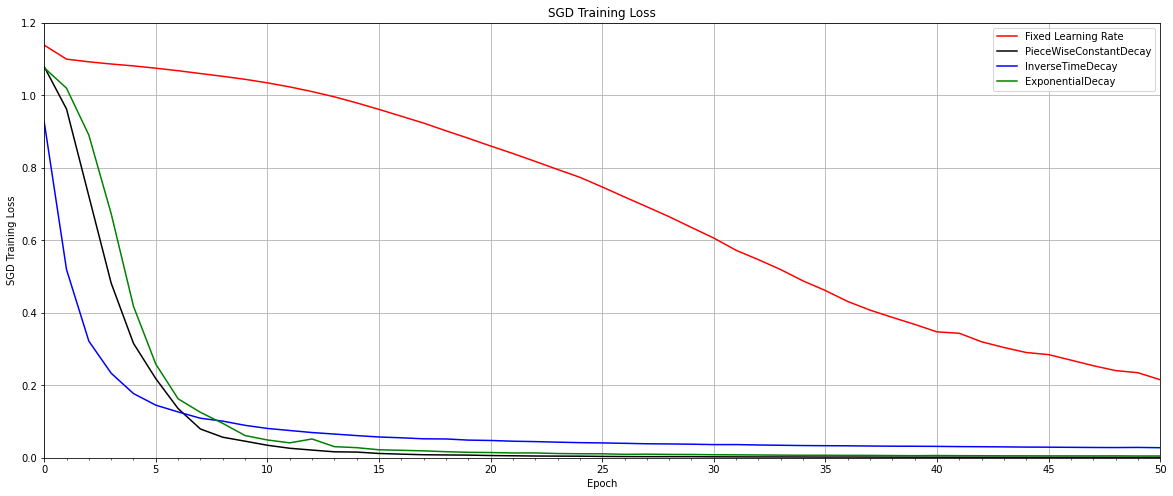

In [ ]:
train_loss_fix = training_results_FIX.history['loss']
train_loss_pcd = training_results_PCD.history['loss']
train_loss_itd = training_results_ITD.history['loss']
train_loss_exp = training_results_EXP.history['loss']
 
plot_results([ train_loss_fix, train_loss_pcd, train_loss_itd, train_loss_exp ], 
            ylabel="SGD Training Loss",
            ylim = [0.0, 1.2],
            metric_name=["Fixed Learning Rate", "PieceWiseConstantDecay", "InverseTimeDecay", "ExponentialDecay"],
            color=['r', 'k', 'b', 'g'])

## 9 Conclusion

In this notebook, we explored the use of three different learning rate schedulers and found that they can dramatically improve the convergence rate of the model. As is often the case in deep learning, experimentation is often required and recommended to confirm which settings work best for your particular problem. Selecting an appropriate optimizer and learning rate scheduler can make a big difference in the amount of time required to train your model and can sometimes lead to higher accuracy as well. 